# Fashion MNIST use tf.keras.utils.image_dataset_from_directory

# 필요한 module import

In [73]:
import os
import PIL
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input

## tf.keras.preprocessing.image_dataset_from_directory 매개변수 정의

In [102]:
batch_size = 128
img_height = 28
img_width = 28

## data load

In [103]:
data_dir = './Img_data/train'

In [104]:
# train data load
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60000 files belonging to 10 classes.
Using 48000 files for training.


In [105]:
# val data load
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60000 files belonging to 10 classes.
Using 12000 files for validation.


In [106]:
test_dir = './Img_data/test'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 10 classes.


## class nam 확인

In [108]:
class_names = train_ds.class_names
class_names_test = test_ds.class_names
print(class_names)
print(class_names_test)

['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt-top', 'Trouser']
['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt-top', 'Trouser']


## Data 시각화

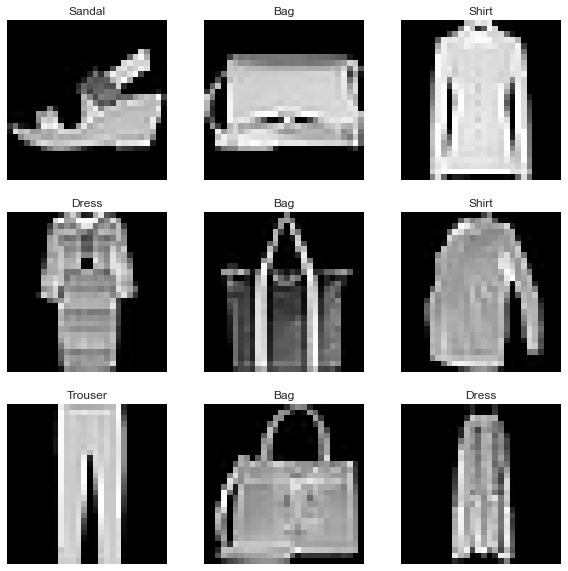

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## data shape

In [80]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 28, 28, 3)
(128,)


In [109]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 28, 28, 3)
(128,)


In [110]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Dataset.cache()는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

## data rescaling

In [82]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [56]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [84]:
num_classes = 10

model_1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [85]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 28, 28, 3)         0         
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 flatten_6 (Flatten)         (None, 50176)             0         
                                                                 
 dense_17 (Dense)            (None, 128)               6422656   
                                                                 
 dense_18 (Dense)            (None, 64)               

In [87]:
epochs=10
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=128
)

Epoch 1/10


/Users/hoon/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-08-18 21:44:00.909267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8533

2022-08-18 21:44:35.404705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 38s 88ms/step - loss: 0.4085 - accuracy: 0.8533 - val_loss: 0.3112 - val_accuracy: 0.8888
Epoch 2/10
375/375 [==============================] - 30s 80ms/step - loss: 0.2362 - accuracy: 0.9139 - val_loss: 0.2599 - val_accuracy: 0.9047
Epoch 3/10
375/375 [==============================] - 28s 74ms/step - loss: 0.1707 - accuracy: 0.9366 - val_loss: 0.2641 - val_accuracy: 0.9130
Epoch 4/10
375/375 [==============================] - 27s 72ms/step - loss: 0.1185 - accuracy: 0.9563 - val_loss: 0.2649 - val_accuracy: 0.9103
Epoch 5/10
375/375 [==============================] - 27s 71ms/step - loss: 0.0769 - accuracy: 0.9717 - val_loss: 0.2921 - val_accuracy: 0.9119
Epoch 6/10
375/375 [==============================] - 26s 70ms/step - loss: 0.0472 - accuracy: 0.9830 - val_loss: 0.3548 - val_accuracy: 0.9147
Epoch 7/10
375/375 [==============================] - 27s 72ms/step - loss: 0.0358 - accuracy: 0.9868 - val_loss: 0.3703 - val_accuracy: 0.9112
Epo

In [88]:
history_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

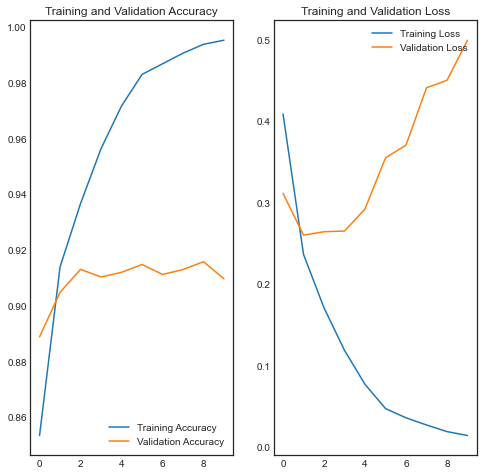

In [89]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss=history_1.history['loss']
val_loss=history_1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

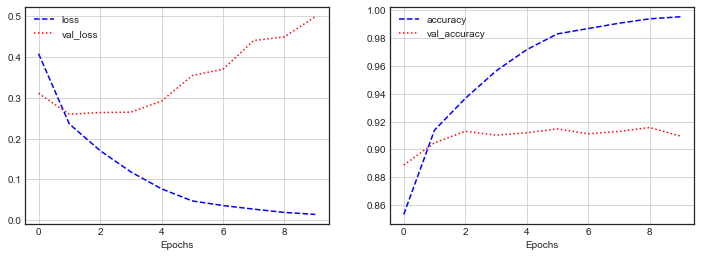

In [90]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], 'b--', label='loss')
plt.plot(history_1.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], 'b--', label='accuracy')
plt.plot(history_1.history['val_accuracy'], 'r:', label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [111]:
model_1.evaluate(test_ds)

79/79 [==============================] - 4s 41ms/step - loss: 0.4306 - accuracy: 0.9200


[0.43055281043052673, 0.9200000166893005]

In [138]:
model_2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(strides=(2, 2)),
  layers.Dropout(0.5),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(256, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(strides=(2, 2)),
  layers.Dropout(0.5),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),

  layers.Dense(64, activation='relu'),
  layers.Dropout(0.5),

  layers.Dense(num_classes, activation='softmax')
])

In [139]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [140]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 28, 28, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 conv2d_37 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 13, 13, 128)       73856     
                                                     

In [141]:
epochs=10
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=128
)

Epoch 1/10


/Users/hoon/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-08-18 23:07:07.015512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 0.8095 - accuracy: 0.7083

2022-08-18 23:07:36.933508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 32s 84ms/step - loss: 0.8095 - accuracy: 0.7083 - val_loss: 0.4184 - val_accuracy: 0.8457
Epoch 2/10
375/375 [==============================] - 29s 77ms/step - loss: 0.3921 - accuracy: 0.8593 - val_loss: 0.3539 - val_accuracy: 0.8695
Epoch 3/10
375/375 [==============================] - 31s 83ms/step - loss: 0.2735 - accuracy: 0.9000 - val_loss: 0.2961 - val_accuracy: 0.8951
Epoch 4/10
375/375 [==============================] - 25s 68ms/step - loss: 0.1960 - accuracy: 0.9265 - val_loss: 0.3088 - val_accuracy: 0.8954
Epoch 5/10
375/375 [==============================] - 23s 60ms/step - loss: 0.1442 - accuracy: 0.9474 - val_loss: 0.3231 - val_accuracy: 0.9042
Epoch 6/10
375/375 [==============================] - 22s 58ms/step - loss: 0.1048 - accuracy: 0.9613 - val_loss: 0.3464 - val_accuracy: 0.9017
Epoch 7/10
375/375 [==============================] - 22s 60ms/step - loss: 0.0828 - accuracy: 0.9705 - val_loss: 0.4249 - val_accuracy: 0.9070
Epo

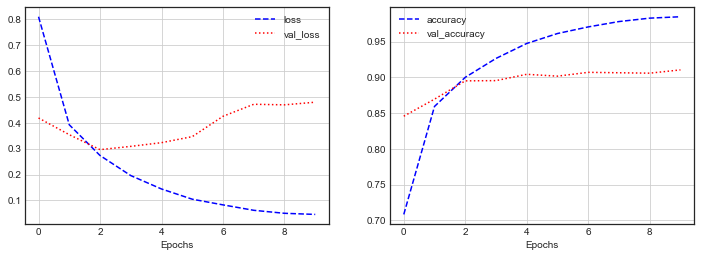

In [142]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], 'b--', label='loss')
plt.plot(history_2.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
#plt.axis([0, 10, 0, 0.8])
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], 'b--', label='accuracy')
plt.plot(history_2.history['val_accuracy'], 'r:', label='val_accuracy')
plt.xlabel('Epochs')
#plt.axis([0, 10, 0.7, 1])
plt.grid()
plt.legend()

plt.show()

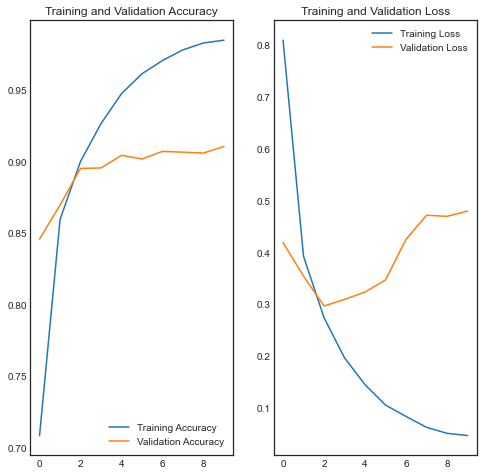

In [143]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss=history_2.history['loss']
val_loss=history_2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [144]:
model_2.evaluate(test_ds)

79/79 [==============================] - 3s 32ms/step - loss: 0.4285 - accuracy: 0.9141


[0.4285469055175781, 0.9141000509262085]

In [145]:
preditions = model_2.predict(test_ds)
print(preditions[0])
print(np.argmax(preditions[0]))

2022-08-18 23:17:20.237981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[4.6047597e-12 3.7301159e-14 2.4947776e-06 9.9999750e-01 4.9418419e-10
 1.4096915e-13 3.2244463e-10 1.0241106e-14 1.4894386e-08 4.3051532e-10]
3


In [132]:
model_3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(strides=(2, 2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(strides=(2, 2)),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(strides=(2, 2)),
  layers.Dropout(0.5),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),

  layers.Dense(64, activation='relu'),
  layers.Dropout(0.3),

  layers.Dense(num_classes, activation='softmax')
])

In [133]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [137]:
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 28, 28, 3)         0         
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 5, 5, 128)        

In [134]:
epochs=10
history_3 = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=128
)

Epoch 1/10


/Users/hoon/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-08-18 23:01:46.949613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


374/375 [============================>.] - ETA: 0s - loss: 0.8221 - accuracy: 0.7010

2022-08-18 23:01:55.160807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 10s 25ms/step - loss: 0.8212 - accuracy: 0.7013 - val_loss: 0.4625 - val_accuracy: 0.8292
Epoch 2/10
375/375 [==============================] - 11s 30ms/step - loss: 0.4424 - accuracy: 0.8389 - val_loss: 0.3746 - val_accuracy: 0.8664
Epoch 3/10
375/375 [==============================] - 7s 19ms/step - loss: 0.3515 - accuracy: 0.8726 - val_loss: 0.3636 - val_accuracy: 0.8658
Epoch 4/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2931 - accuracy: 0.8928 - val_loss: 0.3328 - val_accuracy: 0.8787
Epoch 5/10
375/375 [==============================] - 7s 19ms/step - loss: 0.2495 - accuracy: 0.9078 - val_loss: 0.3317 - val_accuracy: 0.8858
Epoch 6/10
375/375 [==============================] - 10s 27ms/step - loss: 0.2179 - accuracy: 0.9191 - val_loss: 0.3085 - val_accuracy: 0.8910
Epoch 7/10
375/375 [==============================] - 7s 19ms/step - loss: 0.1887 - accuracy: 0.9302 - val_loss: 0.3108 - val_accuracy: 0.8915
Epoch 8

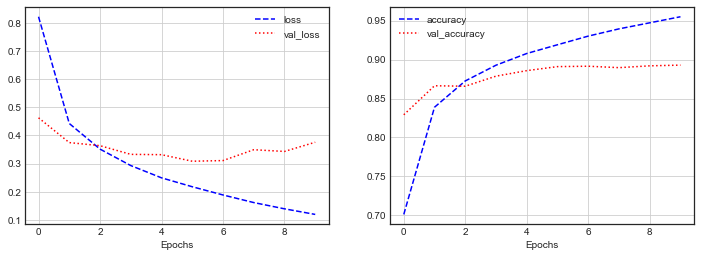

In [135]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_3.history['loss'], 'b--', label='loss')
plt.plot(history_3.history['val_loss'], 'r:', label='val_loss')
plt.xlabel('Epochs')
#plt.axis([0, 10, 0, 0.8])
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3.history['accuracy'], 'b--', label='accuracy')
plt.plot(history_3.history['val_accuracy'], 'r:', label='val_accuracy')
plt.xlabel('Epochs')
#plt.axis([0, 10, 0.7, 1])
plt.grid()
plt.legend()

plt.show()

In [136]:
model_3.evaluate(train_ds)

375/375 [==============================] - 5s 12ms/step - loss: 0.2552 - accuracy: 0.9176


[0.255185604095459, 0.9175833463668823]